In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline


In [2]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [3]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
# root = save directory
# train = MNIST data set includes test and train data. We want train data
# download = We want to download the MNIST data to our local google colab
# transformer = we want to transform it from images to a tensor before loading it in


In [4]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Create a small batch size for images. We'll do 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [8]:
# Define our CNN model
# - padding: Look at the images from our data set. Notice that numbers dont actually reach the sides of the image.
    #        The convolutional layer will drop that "dead space" if we dont set some padding. It doesnt matter much in this dataset but for others it likely will.
# Describe convolutional layer and what its doing (2 convolutional layers)
conv1 =  nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
# Remember, that the input in layer 2 will match the output from the previous layer
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

In [9]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
  break


In [10]:
X_train.shape # 1 image, size 28x28 pixels.

torch.Size([1, 28, 28])

In [11]:
x = X_train.view(1,1,28,28) # 1 batch, of 1 image, of 28 pixels, of 28 pixels

In [12]:
# Perform our first convolutions
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation function.

In [13]:
# 1 image, 6 is the filters we asked for (6 feature maps, 6 filters), and now 26 by 26 pixels. Data surrounding the image is lost (since numbers dont usually go past the center)
x.shape # Now the convolution layer has been run, and this came out on the other side.


torch.Size([1, 6, 26, 26])

In [14]:
# pas thru the pooling layer
x = F.max_pool2d(x, 2, 2) # kernal size of 2 and a stride size of 2

In [15]:
# 1 image, 6 as before, 14 x 14 means that the pixels have been taken away and got smaller. 26/2 = 13.
x.shape

torch.Size([1, 6, 13, 13])

In [16]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [17]:
# 1 image, 16 features (as was defined in the 2nd conv layer), 14 x 14 pixels. If we didnt set padding, this would be smaller.
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
# Another pooling layer
x = F.max_pool2d(x, 2, 2)

In [19]:
# 11 / 2 = 5.5 but we have to round down, because you cant invent data to round up.
x.shape

torch.Size([1, 16, 5, 5])

In [20]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()

    # This is the same as the conv variables from earlier in the notebook, but now in our class
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)

    # Fully Connected Layer
    # - in_features: We take the output from x.shape in the last shell and multiply it together
    # - out_features: arbitrary. flatten out to 120 neurons
    # Remember, the input features should match the output of the previous layer
    self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  # Foward function to push everything foward through the conv layer, pool layer, and connected layer
  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and stride 2
    # Second pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernal and stride 2

    # Re-View to flatten it out
    X = X.view(-1,16*5*5) # negative one so that we can vary the batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [22]:
# Create and Instance of our Model
SEED = 645
torch.manual_seed(SEED)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [23]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the learning rate, the longer its gonna take to train

In [25]:
# Importing time just so we can see how long this all takes
import time
start_time = time.time()

# Create Variables to track things and make graphs later
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs. Encompeses all testing and training.
for i in range(epochs):
  trn_corr = 0 # training correct
  tst_corr = 0 # testing correct

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get the predicted values from the training set. Not flattened 2D.
    loss = criterion(y_pred, y_train) # how off are we? Compare the predictions to the correct answers in Y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this specific batch. True = 1, False = 0, we will sum this up.
    trn_corr += batch_corr # keep track as we go along in training.

    # Update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'epoch: {i}  batch: {b}  loss: {loss.item()}  \
      accuracy: {trn_corr.item()*100/(10*b)}%')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  # no_grad means no gradient. This is so we dont update our weights and biases since we are testing
  with torch.no_grad():
    # looks similar to the train for loop, but with test vars now
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      tst_corr += (predicted == y_test).sum() # T=1, F=0, and sum


    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took {total/60} minutes.')

epoch: 0  batch: 600  loss: 0.38479968905448914        accuracy: 76.63333333333334%
epoch: 0  batch: 1200  loss: 0.016370628029108047        accuracy: 84.975%
epoch: 0  batch: 1800  loss: 0.13068202137947083        accuracy: 88.27222222222223%
epoch: 0  batch: 2400  loss: 0.15564629435539246        accuracy: 90.15%
epoch: 0  batch: 3000  loss: 0.5926915407180786        accuracy: 91.38333333333334%
epoch: 0  batch: 3600  loss: 0.05764617398381233        accuracy: 92.32777777777778%
epoch: 0  batch: 4200  loss: 0.007840346544981003        accuracy: 93.00714285714285%
epoch: 0  batch: 4800  loss: 0.390677273273468        accuracy: 93.51666666666667%
epoch: 0  batch: 5400  loss: 0.11010628938674927        accuracy: 93.95555555555555%
epoch: 0  batch: 6000  loss: 0.002221571747213602        accuracy: 94.305%
epoch: 1  batch: 600  loss: 0.13101726770401        accuracy: 97.93333333333334%
epoch: 1  batch: 1200  loss: 0.03050408884882927        accuracy: 97.84166666666667%
epoch: 1  batch: 18

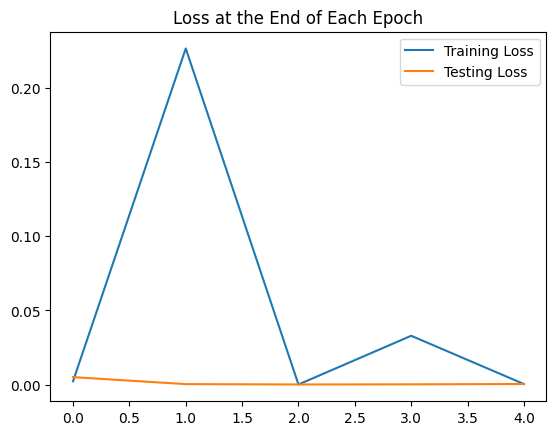

In [28]:
# Graph the loss at each epoch

# Convert tensors to python list
train_losses = [tl.item() for tl in train_losses]
test_losses = [tl.item() for tl in test_losses]

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.title('Loss at the End of Each Epoch')
plt.legend()

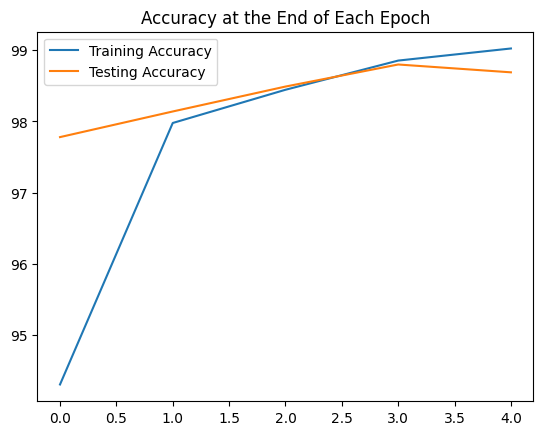

In [29]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy at the End of Each Epoch')
plt.legend()

In [30]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False) # 10,000 because thats how many images we have

In [36]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val.data, 1)[1]
    correct += (predicted == y_test).sum()
  print(f'Test Accuracy: {correct.item()/10000*100}%')

Test Accuracy: 98.69%


In [37]:
# Grab an image
test_data[4143] # Gives a tensor with an image in it...at end, it shows the label (whats the number the image is showing)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [38]:
# We know its a 9. We will just grab the data without the label in it.
# Reshape as well
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

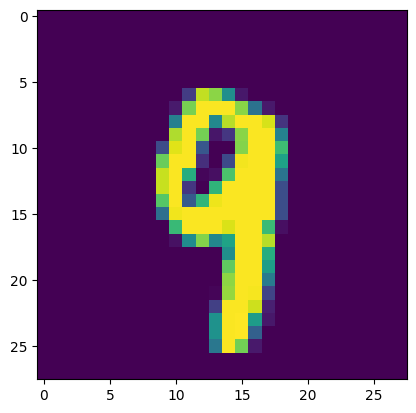

In [39]:
# Show the image
plt.imshow(test_data[4143][0].reshape(28,28))

In [40]:
# Pass image through out model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image


In [41]:
# Check the new prediction...get probabilities for all labels
print(new_prediction)

tensor([[-2.2748e+01, -2.0655e+01, -2.5385e+01, -1.6972e+01, -1.2271e+01,
         -1.9973e+01, -2.9004e+01, -1.5958e+01, -1.5767e+01, -4.8876e-06]])


In [42]:
# We want the biggest probability to see what the cnn thinks it is
new_prediction.argmax()
# Its a 9!

tensor(9)